In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import chain
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from sklearn.feature_selection import mutual_info_regression
import random
import math
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import utils.data_utils as data_utils


sns.set_theme(rc={'grid.linewidth': 0.6, 'grid.color': 'white',
                  'axes.linewidth': 2, 'axes.facecolor': '#ECECEC', 
                  'axes.labelcolor': '#000000',
                  'figure.facecolor': 'white',
                  'xtick.color': '#000000', 'ytick.color': '#000000'})

## I. Data understanding: data quality and EDA

### 1. Loading data

In [2]:
## Initial parameters

# Paths
path_project = str(Path('__file__').absolute().parent)

## Data

# Loading data
data = pd.read_csv(f'{path_project}\\data\\city_pollution_data.csv')

# Prliminary data cleaning
data = data.rename(columns={'Population Staying at Home': 'Pop_at_home', 
                            'Population Not Staying at Home': 'Pop_not_at_home'})

data['Pop_at_home'] = data['Pop_at_home'].str.replace(',', '').astype(int)
data['Pop_not_at_home'] = data['Pop_not_at_home'].str.replace(',', '').astype(int)

# Reduce memory usage
data = data_utils.squeeze_df(df=data)
data['Date'] = pd.to_datetime(data['Date'])

# Target variable (dropping irrelevant pollutants)
pollutants_target = 'pm25_median'
pollutants_drop = ['o3', 'no2_', 'pm10_', 'co_', 'so2_', 'pm25_']
pollutants_drop = [x for x in data.columns if any(x_drop in x for x_drop in pollutants_drop)]
pollutants_drop = list(set(pollutants_drop) - {'pm25_median'})

data = data.drop(columns=pollutants_drop, axis=1)

# Sorting data
data = data.sort_values(by=['City', 'Date']).reset_index(drop=True)

### 2. Data quality: assessment

In [3]:
# Continuous features
continuous_features = data.columns[4:]
data_utils.continuous_features_report(df=data, continuous_features=continuous_features)

Mean     Median         Std  N observations  \
dew_count                  31.66      24.00       17.05         20491.0   
dew_variance               52.92      23.10      169.64         20491.0   
dew_min                     6.82       7.00        9.66         20491.0   
dew_max                    13.04      14.00        8.67         20491.0   
dew_median                 10.01      11.00        8.92         20491.0   
wind-gust_min               0.67       0.20        1.65         34217.0   
wind-gust_max              14.48      13.00        7.95         34217.0   
wind-gust_median            5.34       4.60        3.19         34217.0   
wind-gust_variance        154.27     106.34      389.35         34217.0   
wind-gust_count            81.16      66.00       54.24         34217.0   
wind-speed_median           2.36       2.00        2.39         34646.0   
wind-speed_max              7.66       6.50        6.16         34646.0   
wind-speed_min              0.28       0.10        1.68         34646.0   
wind-speed_count           81.10      65.00       52.91         34646.0   
wind-speed_variance        55.35      24.65      514.40         34646.0   
temperature_max            23.22      24.80       11.98         34658.0   
temperature_count         102.33      72.00       57.60         34658.0   
temperature_variance      229.34     137.22      606.18         34658.0   
temperature_median         15.76      17.00        9.63         34658.0   
temperature_min             9.21      10.20       10.65         34658.0   
humidity_count            102.36      72.00       57.83         34668.0   
humidity_median            64.29      69.80       22.57         34668.0   
humidity_max               88.28      94.00       16.79         34668.0   
humidity_min               36.89      38.10       21.99         34668.0   
pressure_count            103.53      72.00       58.11         34667.0   
pressure_variance       78065.44      65.48   337973.33         34667.0   
pressure_median          1003.66    1015.20      107.81         34667.0   
pressure_max             1023.24    1019.90       40.84         34667.0   
pressure_min              949.85    1009.70      220.72         34667.0   
humidity_variance        2660.05    1920.59     2903.24         34668.0   
pm25_median                31.15      28.00       17.11         35134.0   
Pop_at_home            337261.34  219644.00   382085.15         35596.0   
Pop_not_at_home       1124679.30  738718.00  1256587.42         35596.0   
longitude                 -97.17     -93.10       18.31         35596.0   
latitude                   37.09      37.55        5.23         35596.0   
past_week_avg_miles         0.00       0.00        0.00         35596.0   
mil_miles                  46.86      31.17       52.96         35596.0   
pp_feat                     8.44       1.77       24.63         35596.0   

                      Missing values %  Cardinality       Min  1st Quartile  \
dew_count                        42.43        122.0      2.00         20.00   
dew_variance                     42.43       8738.0      0.00         10.70   
dew_min                          42.43        303.0   -110.50          0.50   
dew_max                          42.43        290.0    -22.70          7.00   
dew_median                       42.43        270.0    -26.00          3.00   
wind-gust_min                     3.87        135.0      0.10          0.10   
wind-gust_max                     3.87        547.0      0.10          9.70   
wind-gust_median                  3.87        235.0      0.10          3.00   
wind-gust_variance                3.87      20540.0      0.00         59.66   
wind-gust_count                   3.87        306.0      2.00         43.00   
wind-speed_median                 2.67        133.0      0.00          1.30   
wind-speed_max                    2.67        373.0      0.00          4.60   
wind-speed_min                    2.67         69.0      0.00          0.10

In [4]:
# Categorical features
categorical_features = data.columns[:4]
data_utils.categorical_features_report(df=data, categorical_features=categorical_features)

N observations  Missing values %  Cardinality
Date           35596.0               0.0        668.0
City           35596.0               0.0         54.0
County         35596.0               0.0         53.0
State          35596.0               0.0         34.0

In [5]:
# Additional info necessary for EDA
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

cities_list = list(data['City'].unique())
states_list = list(data['State'].unique())

In [6]:
# NaNs by city
nulls = data.isnull().sum()
nulls = nulls[nulls > 0].index

nulls_group = data.groupby('City', as_index=False)[nulls].apply(lambda x: x.isnull().sum())
nulls_group_perc = nulls_group.iloc[:, 1:].div(data.groupby('City', as_index=False)['Date'].count()['Date'], axis=0)
nulls_group_perc['City'] = nulls_group['City']
nulls_group_perc = pd.melt(nulls_group_perc, id_vars=['City']).sort_values(by='value')

# Dropping variable `dew` (it has over 40% of NaNs)
nulls_group_perc = nulls_group_perc[~nulls_group_perc['variable'].str.contains('dew')]

# Cities with more than 10% of NaNs
nulls_group_perc_high_nan = nulls_group_perc[nulls_group_perc['value'] >= 0.05]
nulls_group_perc_high_nan

City              variable     value
640     san diego       temperature_min  0.065104
586     san diego        humidity_count  0.065104
424     san diego          humidity_max  0.065104
802     san diego  temperature_variance  0.065104
1612    san diego    wind-gust_variance  0.065104
748     san diego    temperature_median  0.065104
1666    san diego       wind-gust_count  0.065104
478     san diego       humidity_median  0.065104
370     san diego          humidity_min  0.065104
532     san diego     humidity_variance  0.065104
1450    san diego         wind-gust_min  0.065104
1558    san diego      wind-gust_median  0.065104
1504    san diego         wind-gust_max  0.065104
154     san diego       pressure_median  0.065104
694     san diego       temperature_max  0.065104
46      san diego          pressure_min  0.065104
208     san diego     pressure_variance  0.065104
262     san diego        pressure_count  0.065104
856     san diego     temperature_count  0.065104
100     san diego          pressure_max  0.065104
1288    san diego     wind-speed_median  0.067708
1180    san diego        wind-speed_min  0.067708
1234    san diego        wind-speed_max  0.067708
1342    san diego   wind-speed_variance  0.067708
1396    san diego      wind-speed_count  0.067708
1305     columbia   wind-speed_variance  0.069091
1251     columbia     wind-speed_median  0.069091
1143     columbia        wind-speed_min  0.069091
1359     columbia      wind-speed_count  0.069091
1197     columbia        wind-speed_max  0.069091
1476     honolulu         wind-gust_max  0.101796
1584     honolulu    wind-gust_variance  0.101796
1638     honolulu       wind-gust_count  0.101796
1530     honolulu      wind-gust_median  0.101796
1422     honolulu         wind-gust_min  0.101796
1636       fresno       wind-gust_count  0.134731
1420       fresno         wind-gust_min  0.134731
1474       fresno         wind-gust_max  0.134731
1582       fresno    wind-gust_variance  0.134731
1528       fresno      wind-gust_median  0.134731
1637     hartford       wind-gust_count  0.148204
1529     hartford      wind-gust_median  0.148204
1583     hartford    wind-gust_variance  0.148204
1475     hartford         wind-gust_max  0.148204
1421     hartford         wind-gust_min  0.148204
1473   fort worth         wind-gust_max  0.182504
1581   fort worth    wind-gust_variance  0.182504
1419   fort worth         wind-gust_min  0.182504
1527   fort worth      wind-gust_median  0.182504
1635   fort worth       wind-gust_count  0.182504
310      richmond           pm25_median  0.211094
1428  little rock         wind-gust_min  0.245509
1590  little rock    wind-gust_variance  0.245509
1536  little rock      wind-gust_median  0.245509
1644  little rock       wind-gust_count  0.245509
1482  little rock         wind-gust_max  0.245509
279      columbia           pm25_median  0.420000

### 3. EDA: spatio-temporal patterns

#### 3.1 Trend analysis (temporal)

In [112]:
data.groupby(['year'], as_index=False)[pollutants_target].agg(['median', 'mean', 
                                                               'std', 'min', 'max']).round(3)

year  median    mean     std  min    max
0  2019    28.0  30.541  13.758  1.0  147.0
1  2020    28.0  31.777  19.923  3.0  507.0

In [113]:
data.groupby('year')[pollutants_target].quantile([0.25, 0.5, 0.75, 0.95, 0.99]).unstack()

0.25  0.50  0.75  0.95  0.99
year                              
2019  21.0  28.0  38.0  56.0  68.0
2020  21.0  28.0  38.0  59.0  94.0

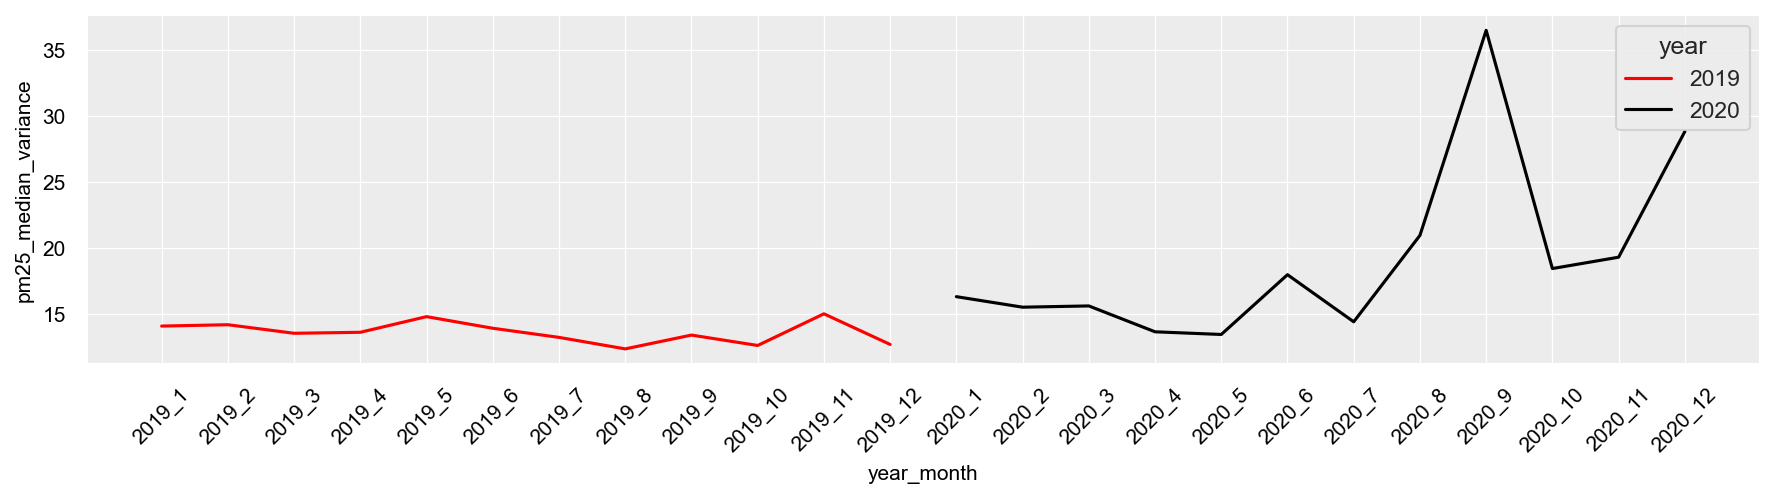

In [14]:
year_month_var = data.groupby(['year', 'month'], as_index=False)['pm25_median'].std()
year_month_var['year_month'] = year_month_var['year'].astype(str) + '_' + year_month_var['month'].astype(str)
year_month_var = year_month_var.rename(columns={'pm25_median': 'pm25_median_variance'})

with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (12, 6))
    ax_flat = axes.flatten()

    sns.lineplot(ax=ax_flat[0], x=year_month_var['year_month'], palette=['#FF0000', '#000000'],
                 y=year_month_var['pm25_median_variance'], hue=year_month_var['year'])
    
    plt.setp(ax_flat[0].get_xticklabels(), rotation=45)
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

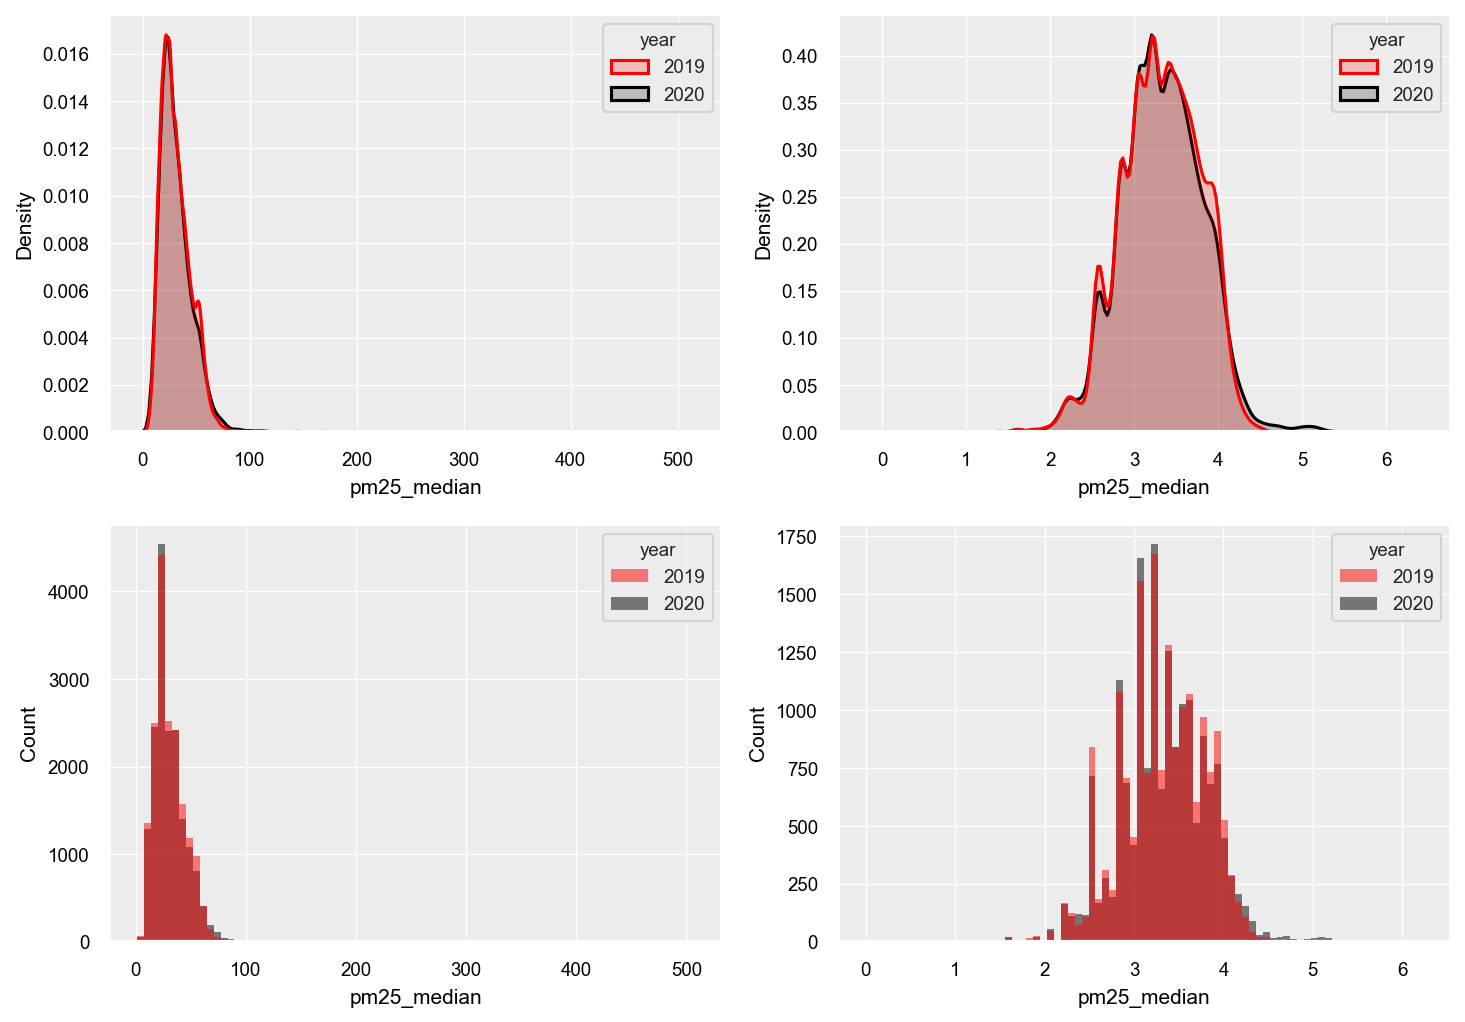

In [114]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9, 
                          'legend.fontsize': 9, 'legend.title_fontsize': 9}):
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 7))
    ax_flat = axes.flatten()

    sns.kdeplot(ax=ax_flat[0], x=data['pm25_median'], palette=['red', 'black'], hue=data['year'],
                fill=True, alpha=0.2, linewidth=1.5)
    
    sns.kdeplot(ax=ax_flat[1], x=np.log(data['pm25_median']), palette=['red', 'black'], hue=data['year'],
                fill=True, alpha=0.2, linewidth=1.5)
    
    sns.histplot(ax=ax_flat[2], x=data['pm25_median'], palette=['red', 'black'], hue=data['year'],
                 bins=80, linewidth=0)
    
    sns.histplot(ax=ax_flat[3], x=np.log(data['pm25_median']), palette=['red', 'black'], hue=data['year'],
                 bins=80, linewidth=0)

plt.tight_layout()
plt.show()

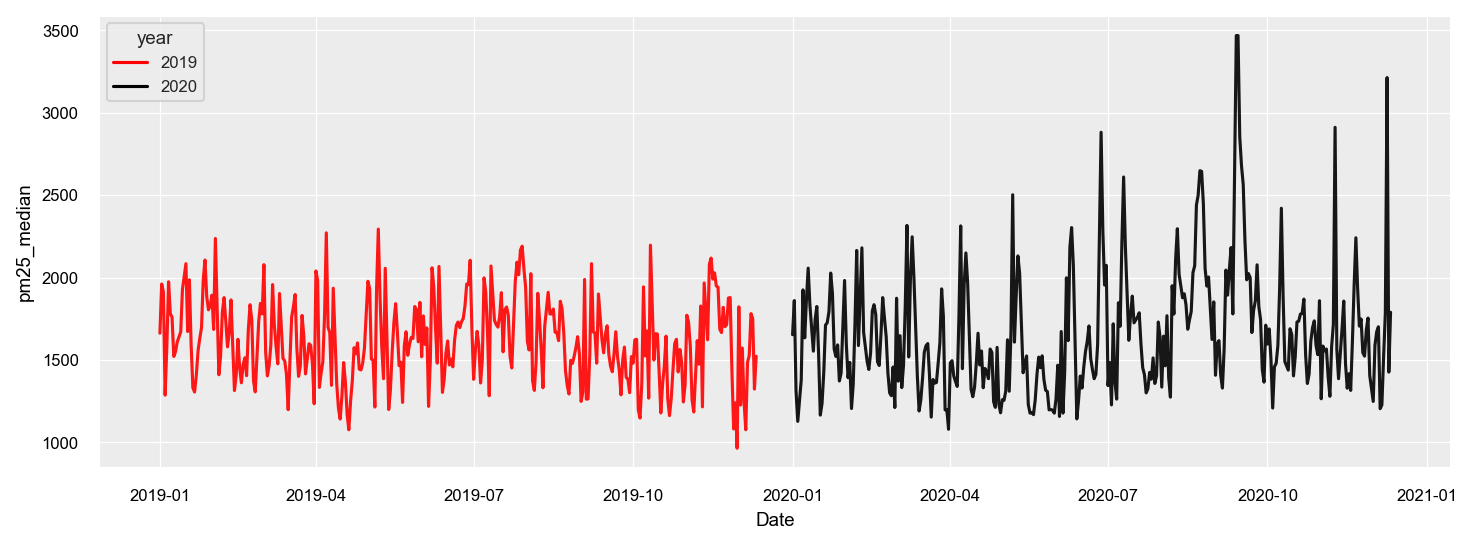

In [115]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                          'legend.fontsize': 8, 'legend.title_fontsize': 9}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    data_year = data.groupby(['Date', 'year'], as_index=False)['pm25_median'].sum()

    sns.lineplot(ax=ax_flat[0], x=data_year['Date'], y=data_year['pm25_median'], 
                 palette=['red', 'black'], hue=data_year['year'],
                 alpha=0.9, linewidth=1.5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

del data_year

#### 3.2 Monthly variability (temporal)

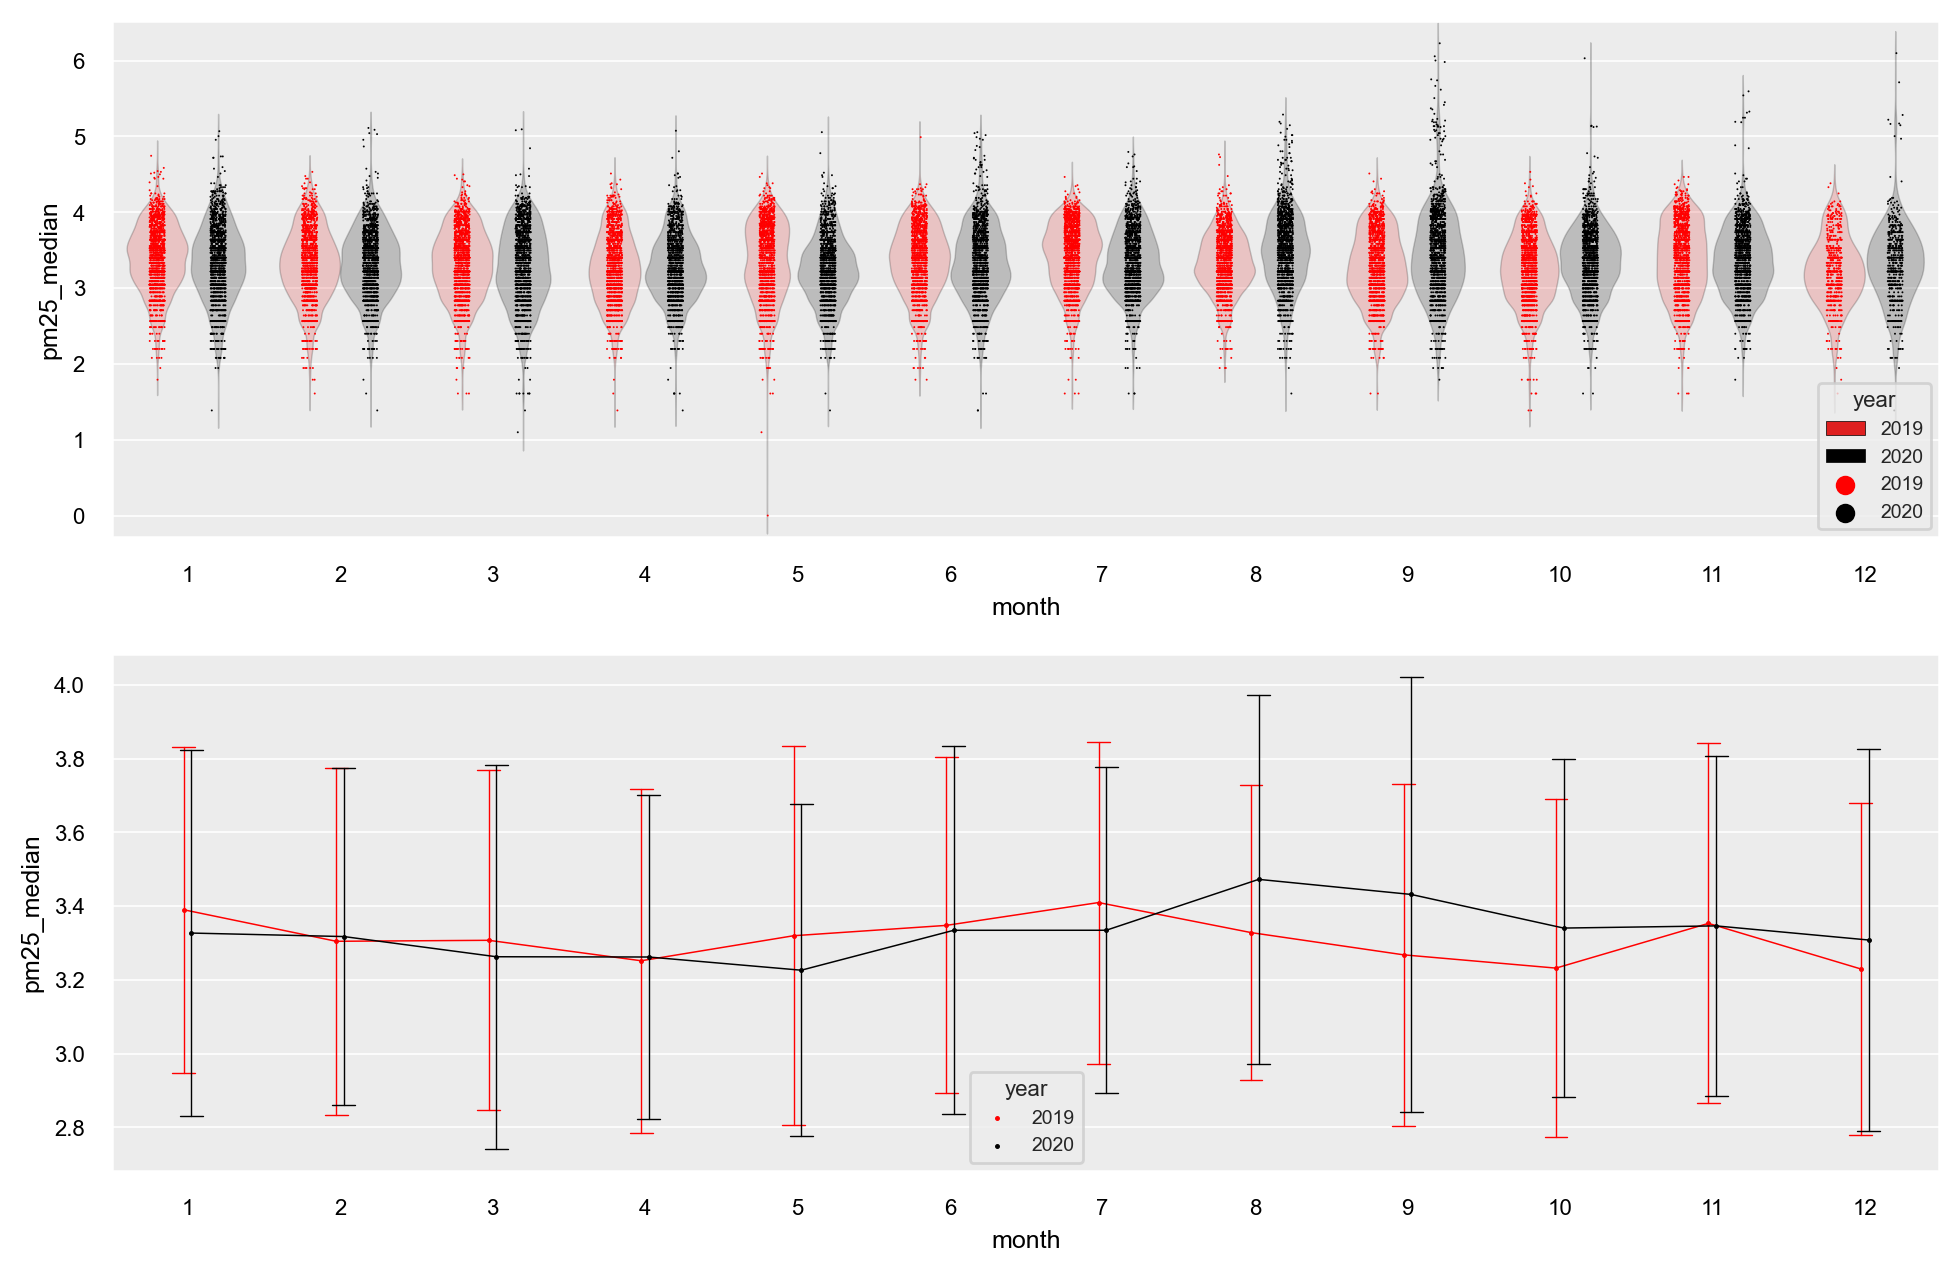

In [116]:
with plt.rc_context(rc={'figure.dpi': 200, 'axes.labelsize': 9, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(2, 1, figsize=(10, 6.5))
    ax_flat = axes.flatten()

    sns.violinplot(ax=ax_flat[0], x=data['month'], y=np.log(data['pm25_median']),
                   palette=['red', 'black'], hue=data['year'], dodge=True, 
                   density_norm='width', linewidth=0.5, inner=None)
    
    plt.setp(ax_flat[0].collections, alpha=0.2)

    sns.stripplot(ax=ax_flat[0], x=data['month'], y=np.log(data['pm25_median']),
                  palette=['red', 'black'], hue=data['year'], dodge=True, s=0.7, alpha=1, jitter=0.1)
    
    sns.pointplot(ax=ax_flat[1], x=data['month'], y=np.log(data['pm25_median']),
                  palette=['red', 'black'], hue=data['year'], dodge=True, 
                  scale=0.2, estimator=np.mean, errorbar='sd', errwidth=0.5, capsize=0.15, join=True)
    
    # ax_flat[1].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

#### 3.3 ACF and PACF plots (spatio-temporal)

In [117]:
random_strings = random.sample(list(data['City'].unique()), 12)
subset = data[data['City'].isin(random_strings)][['City', pollutants_target]]
subset[pollutants_target] = subset[pollutants_target].fillna(np.mean(subset[pollutants_target]))  # Group by City

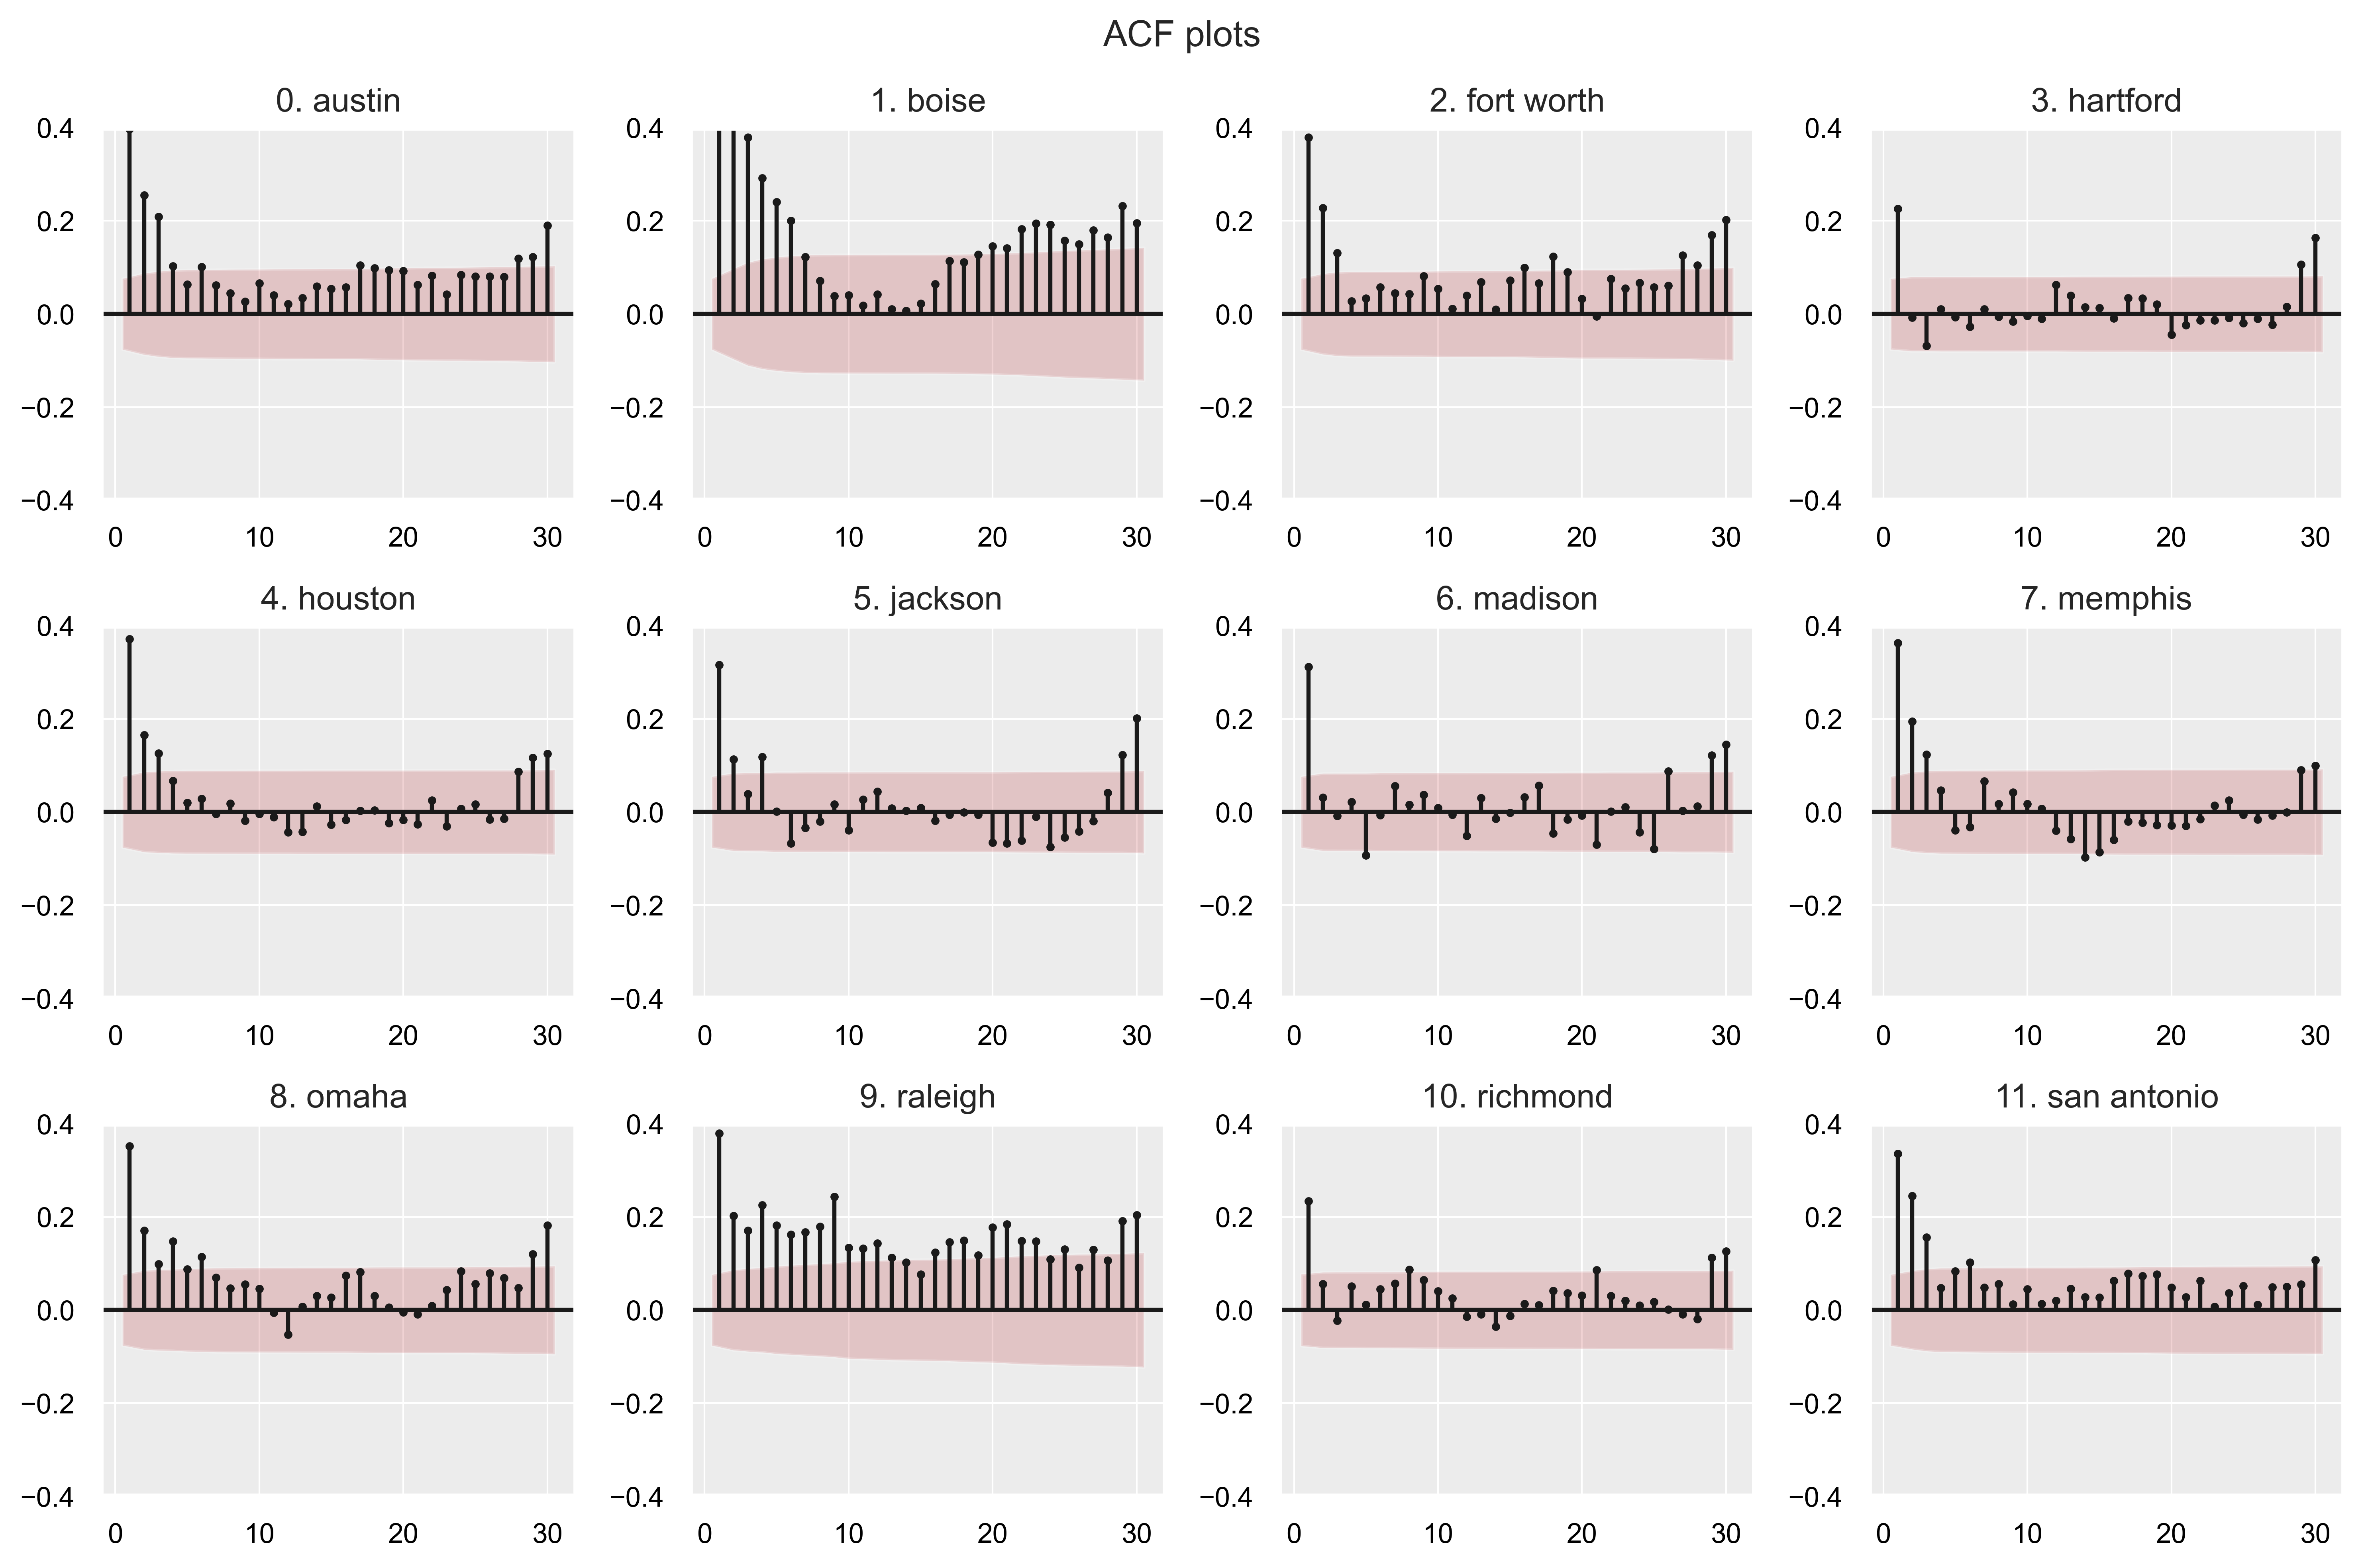

In [118]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11, 
                        'xtick.labelsize': 10, 'ytick.labelsize': 10}): 
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(subset['City'].unique(), ax_flat)):
        tsaplots.plot_acf(subset[subset['City'] == city][pollutants_target].to_numpy(), 
                          lags=30, ax=ax, zero=False,
                          markerfacecolor='k', markeredgecolor='k', markersize=2,
                          vlines_kwargs={"colors": 'k'}, title=f'{idx}. {city}')
        
        ax.collections[1].set_facecolor('r')
        ax.lines[0].set_color('k')
        ax.set_ylim(-0.4, 0.4)
        
    fig.suptitle('ACF plots', fontsize=13)
    plt.tight_layout(pad=1)
    plt.show()

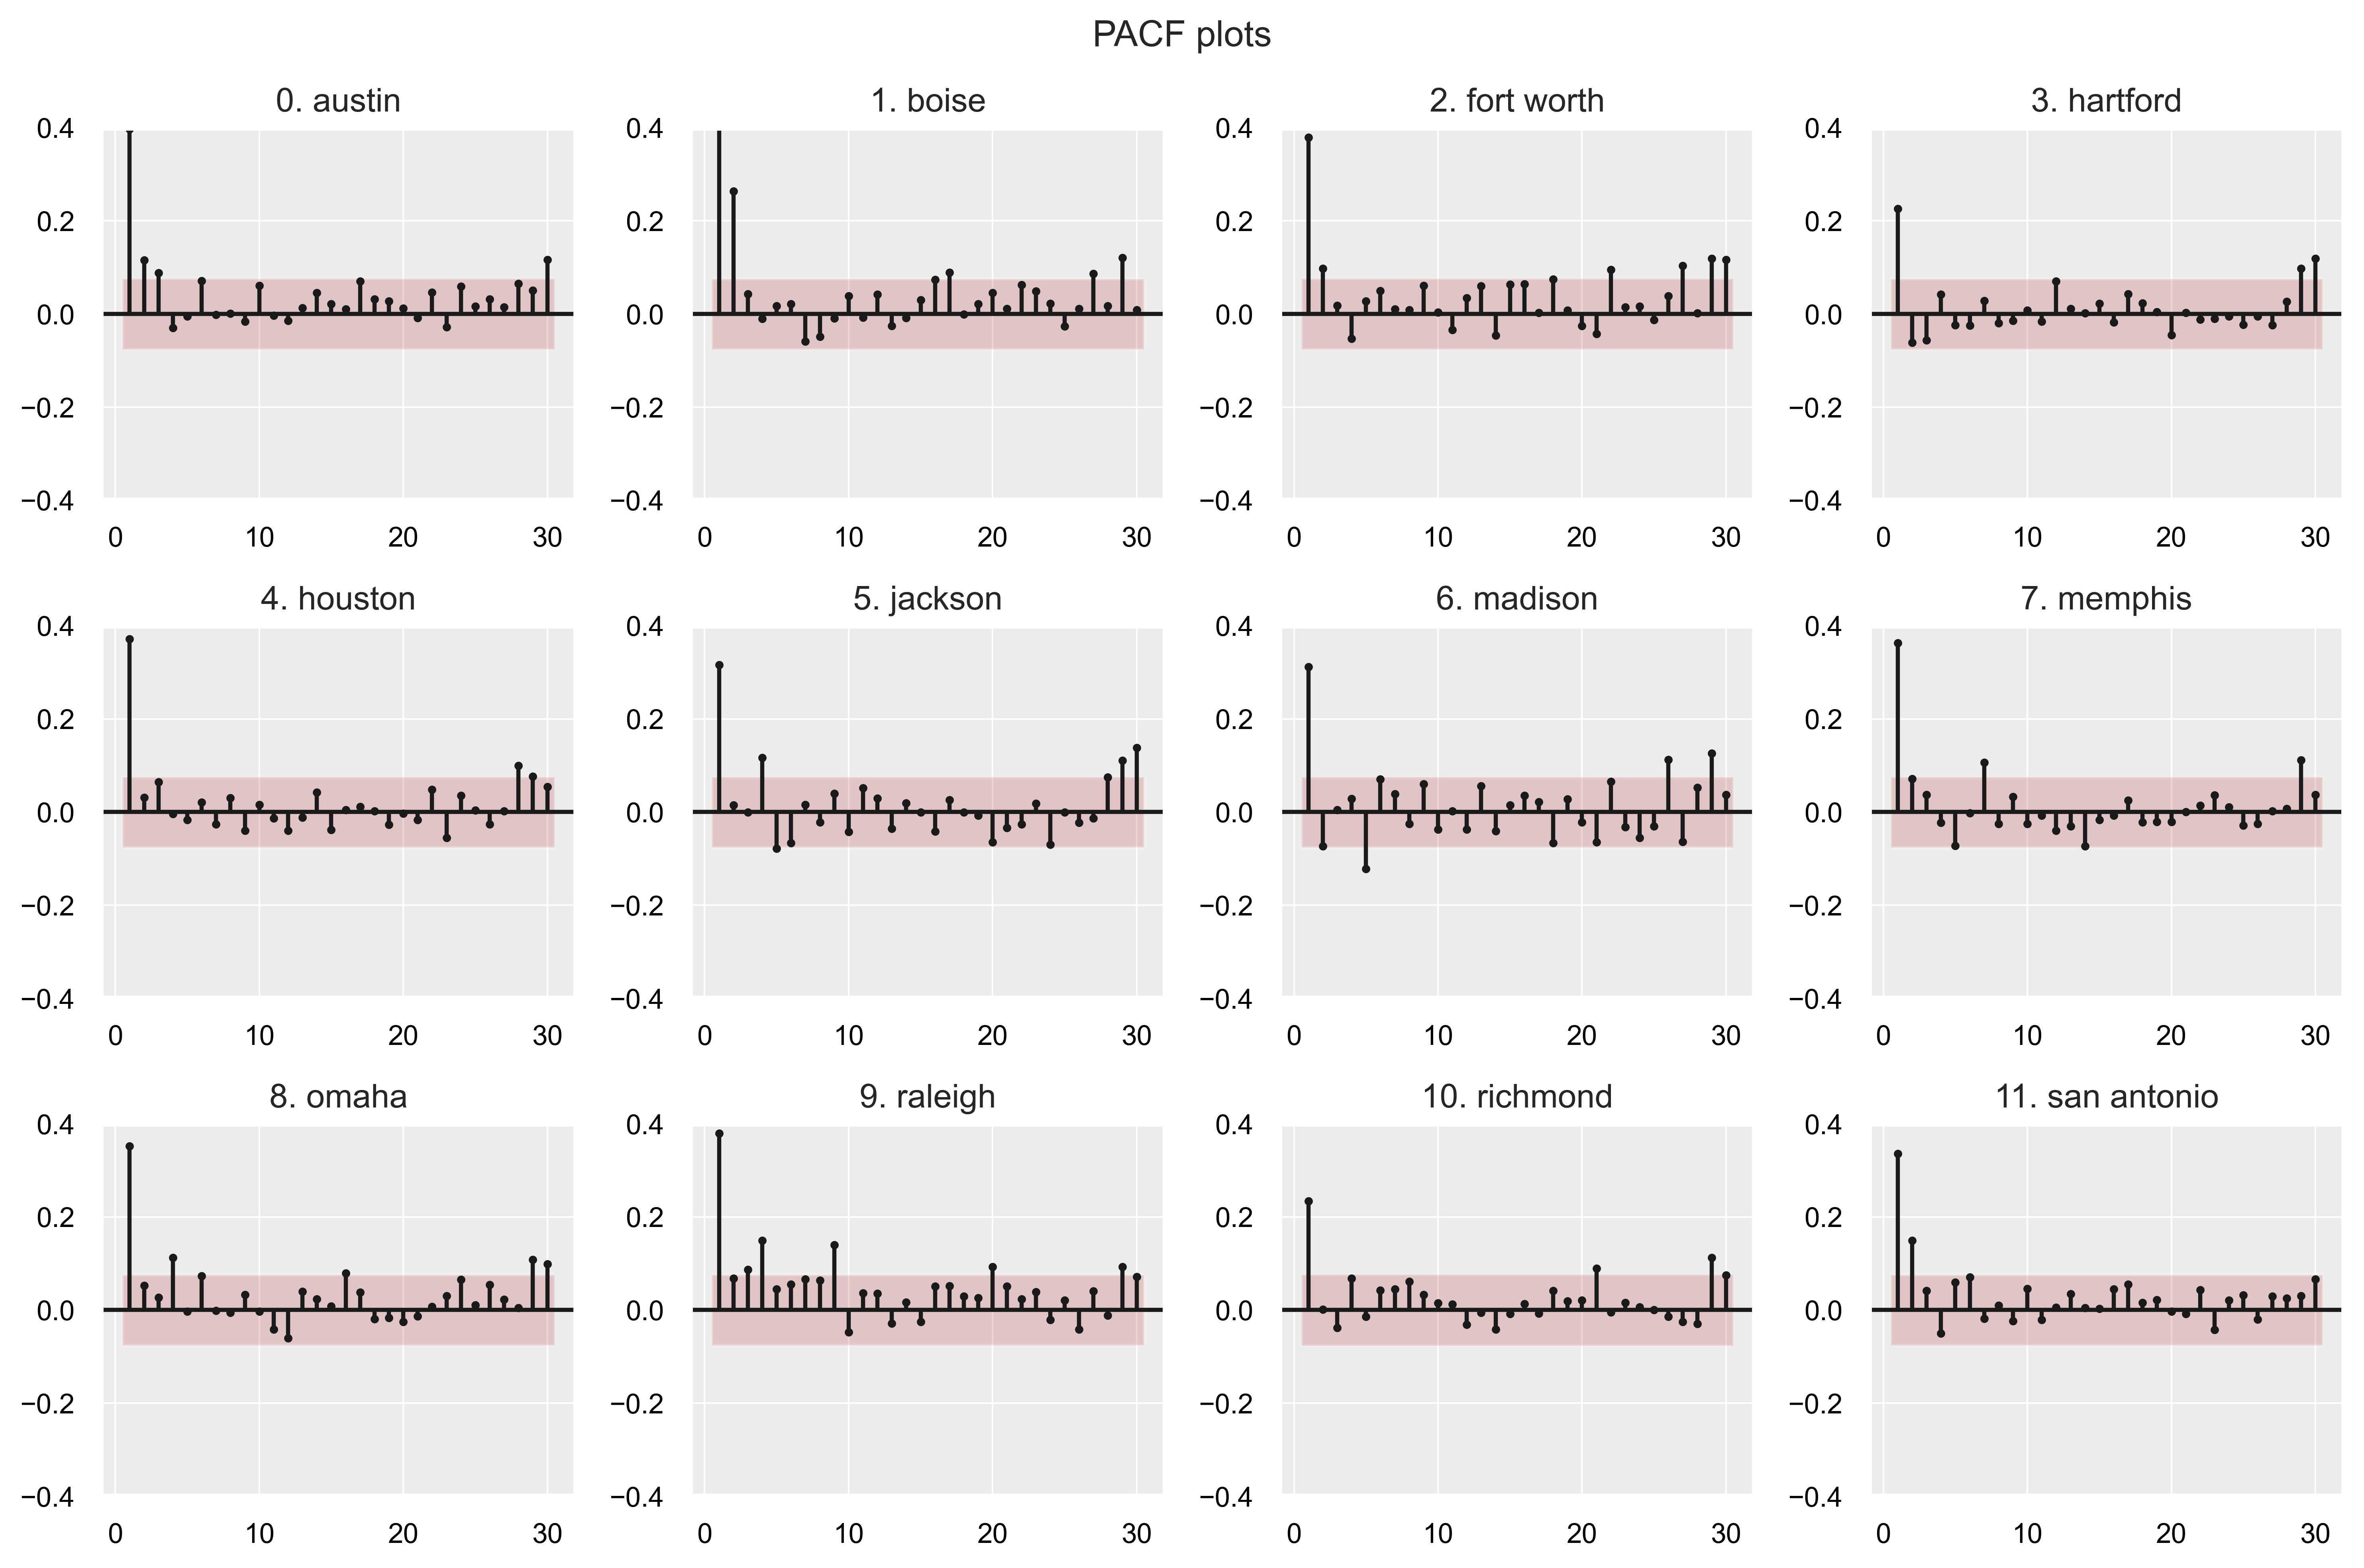

In [119]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11, 
                        'xtick.labelsize': 10, 'ytick.labelsize': 10}): 
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(subset['City'].unique(), ax_flat)):
        tsaplots.plot_pacf(subset[subset['City'] == city][pollutants_target].to_numpy(), 
                           lags=30, ax=ax, zero=False,
                           markerfacecolor='k', markeredgecolor='k', markersize=2,
                           vlines_kwargs={"colors": 'k'}, title=f'{idx}. {city}')
        
        ax.collections[1].set_facecolor('r')
        ax.lines[0].set_color('k')
        ax.set_ylim(-0.4, 0.4)
    
    fig.suptitle('PACF plots', fontsize=13)
    plt.tight_layout(pad=1)
    plt.show()
    
    del subset

#### 3.4 Annual seasonality (spatio-temporal)

In [120]:
data_month_pm25 = data.groupby(['City', 'month', 'year'], as_index=False)[pollutants_target].mean()

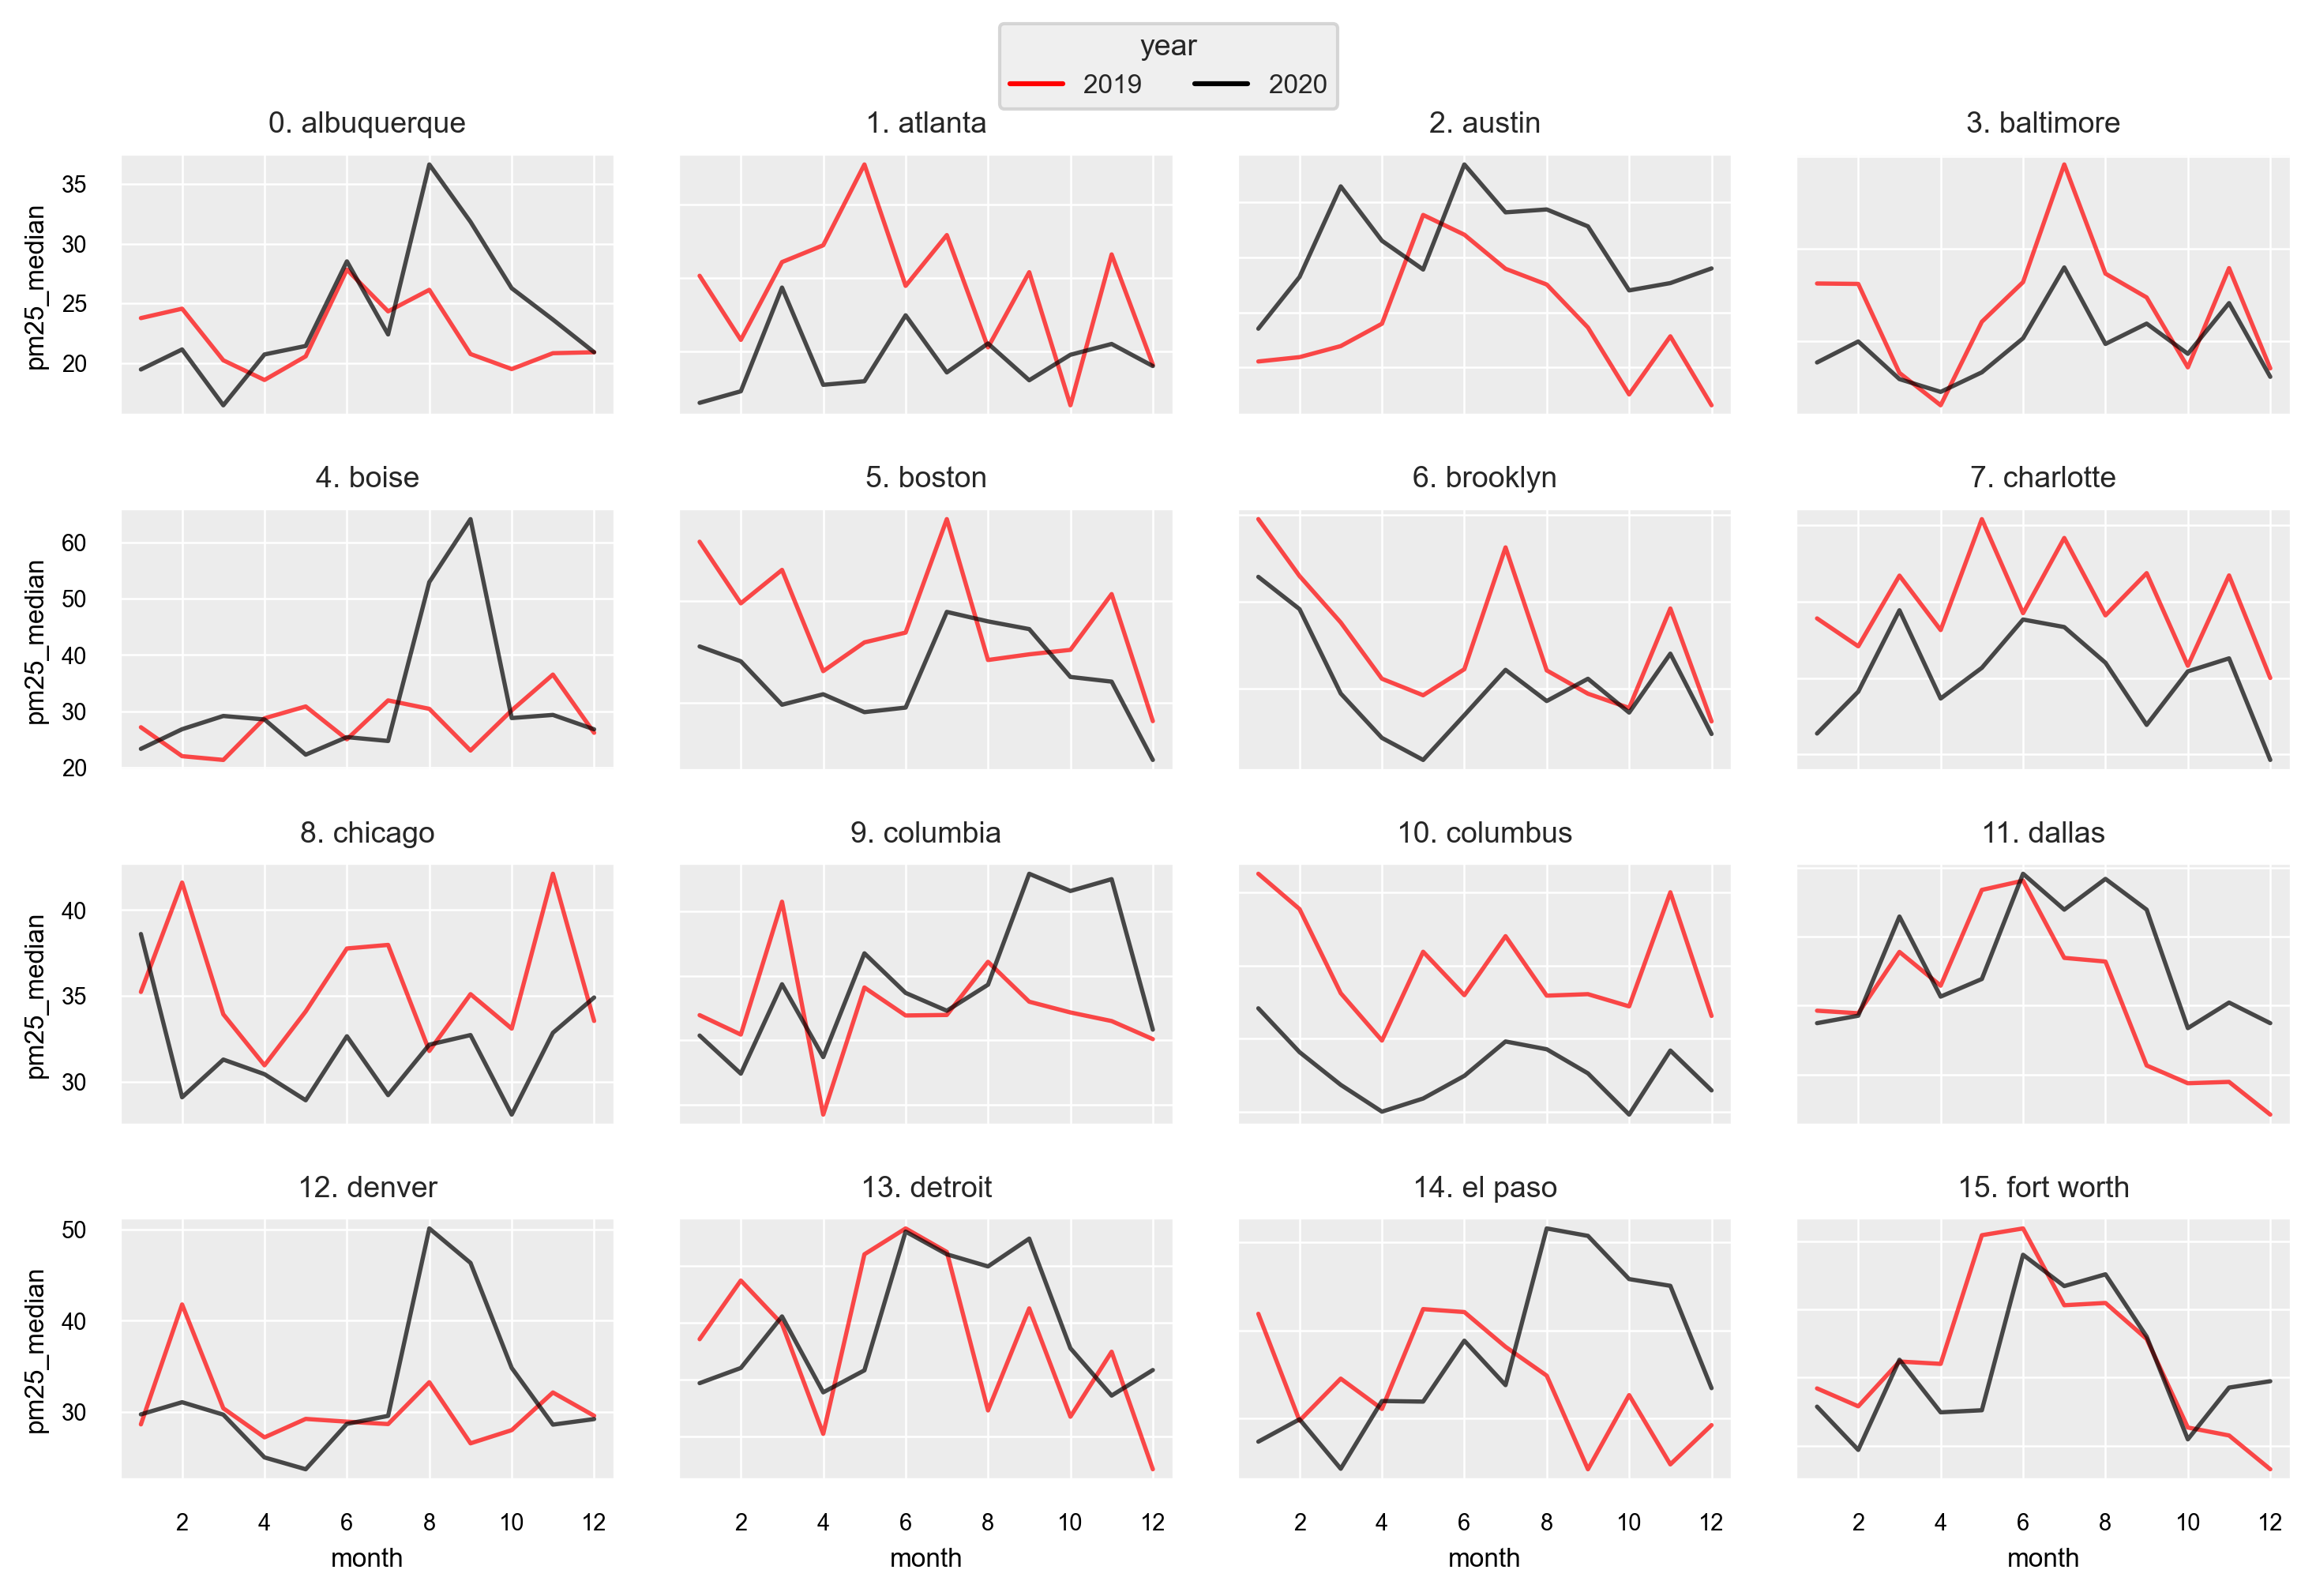

In [121]:
with plt.rc_context(rc={'figure.dpi': 300, 'axes.labelsize': 8, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(int((len(cities_list[0:16]) / 4)), 4, figsize=(10, 6.5))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(cities_list[0:16], ax_flat)):
        subset_city = data_month_pm25.loc[data_month_pm25['City'] == city]
    
        sns.lineplot(ax=ax, x=subset_city['month'], y=subset_city['pm25_median'], 
                     palette=['red', 'black'], hue=subset_city['year'], lw=1.3, alpha=0.7)
        
        ax.get_legend().remove()
        ax.set_title(f'{idx}. {city}', fontsize=9)
        ax.label_outer()

    # Global legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, 
               fontsize=8, title='year', title_fontsize=9)

    plt.tight_layout(pad=1)
    plt.show()

    del subset_city

#### 3.5 Distributions (spatial)

In [122]:
cities_group = [data['City'].unique()[x:x+12] for x in range(0, len(data['City'].unique()), 12)]

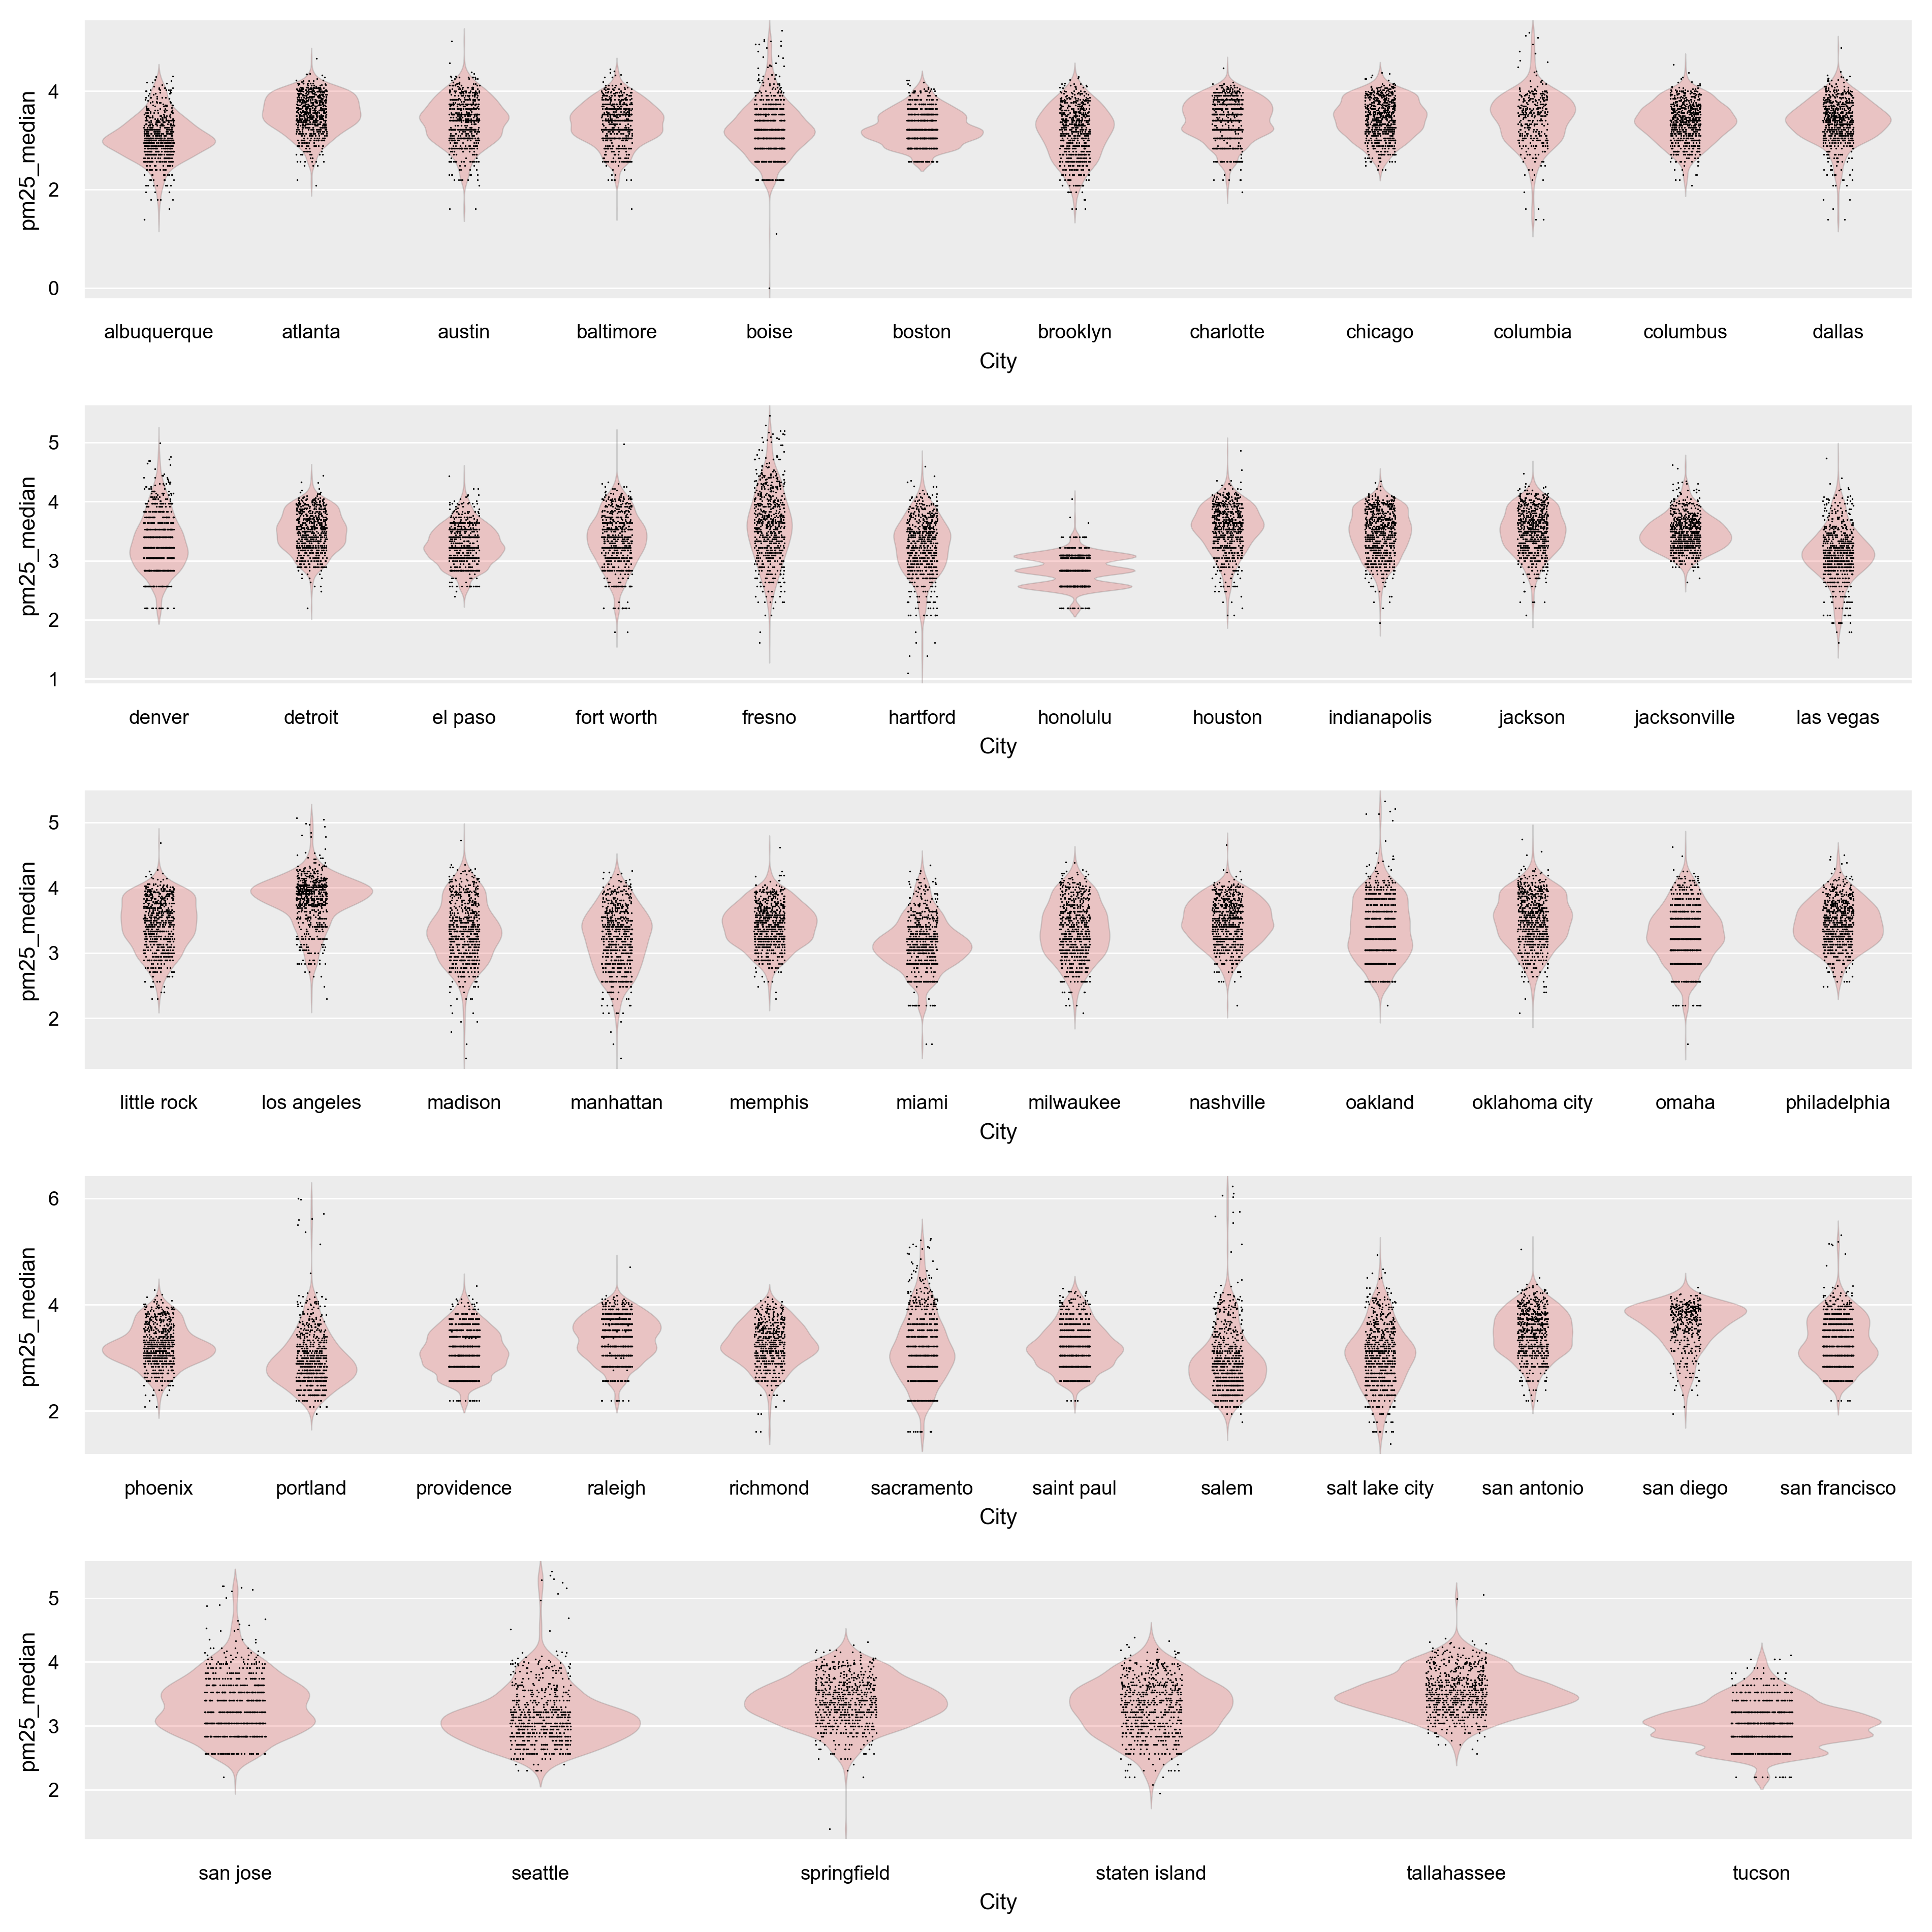

In [123]:
with plt.rc_context(rc={'figure.dpi': 350, 'axes.labelsize': 9, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8}):

    fig, axes = plt.subplots(len(cities_group), 1, figsize=(11, 11))
    ax_flat = axes.flatten()

    for city_group, ax in zip(cities_group, ax_flat):
        subset_city = data.loc[data['City'].isin(city_group)]

        sns.violinplot(ax=ax, x=subset_city['City'], y=np.log(subset_city['pm25_median']),
                       color='red', density_norm='width', linewidth=0.5, inner=None)
        
        plt.setp(ax.collections, alpha=0.2)

        sns.stripplot(ax=ax, x=subset_city['City'], y=np.log(subset_city['pm25_median']),
                      color='black', s=0.7, alpha=1, jitter=0.1)
        
plt.tight_layout(pad=1)
plt.show()

del subset_city

### 4. EDA: multivariate analysis

In [124]:
subset_cols = list(set(data.select_dtypes(include=[int, float]).columns) - {'pm25_median', 'month', 'year'})

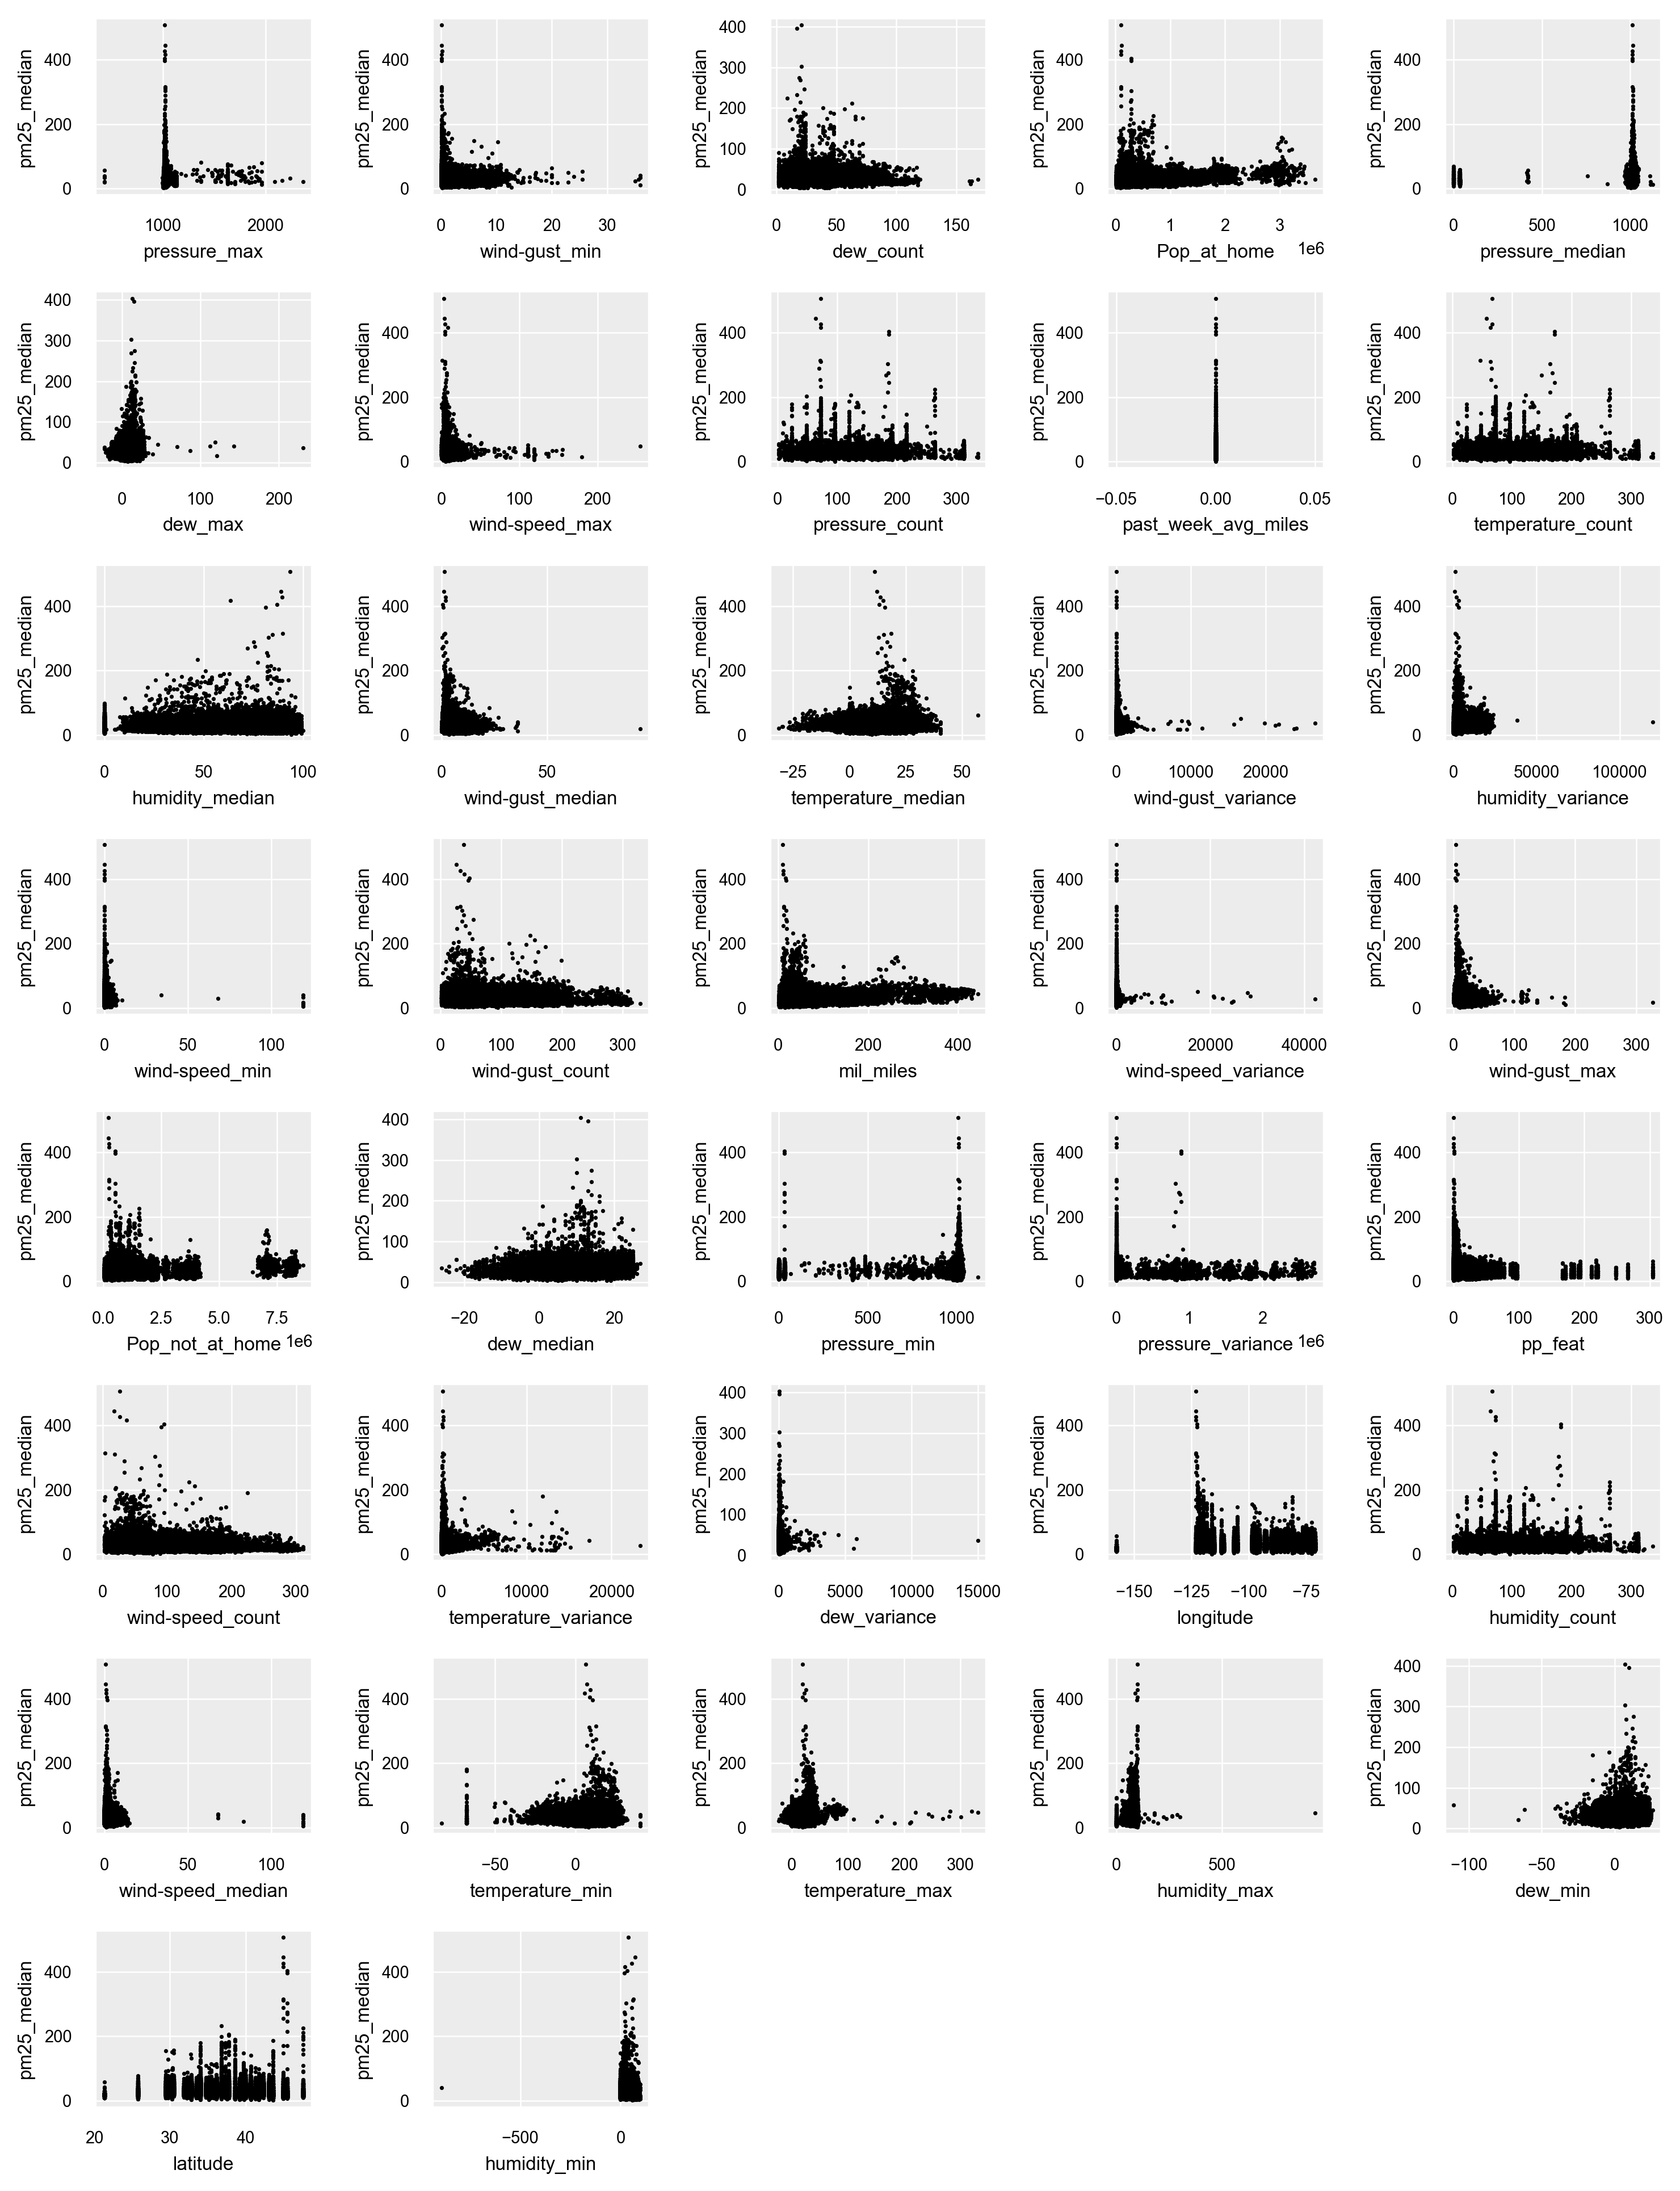

In [125]:
with plt.rc_context(rc={'figure.dpi': 300, 'axes.labelsize': 8, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(8, 5, figsize=(10, 13))
    ax_flat = axes.flatten()

    for idx, (col, ax) in enumerate(zip(subset_cols, ax_flat)):
        sns.scatterplot(ax=ax, x=data[col], y=data['pm25_median'], color='black',
                        linewidth=0, alpha=1, s=3)

    # Removing empty figures
    [axes.set_visible(False) for axes in ax_flat[idx + 1:]]

    plt.tight_layout(pad=1)
    plt.show()

In [126]:
# Dropping a variable with a constant value
data = data.drop('past_week_avg_miles', axis=1)

In [127]:
corr_pearson = data.select_dtypes(include=[int, float]).corrwith(data['pm25_median'], method='pearson')
corr_spearman = data.select_dtypes(include=[int, float]).corrwith(data['pm25_median'], method='spearman')

data_no_nan = data.dropna()
mi_scores = {}

for col in data.select_dtypes(include=[int, float]).columns:
    mi_scores[col] = mutual_info_regression(data_no_nan[[col]], data_no_nan['pm25_median'])[0]

del data_no_nan

data_correlations = pd.DataFrame({'Pearson_correlation': corr_pearson, 
                                  'Spearman_correlation': corr_spearman,
                                  'Mutual_Information': mi_scores})

data_correlations = data_correlations.drop('pm25_median').sort_values(by='Mutual_Information', ascending=False)

data_correlations

Pearson_correlation  Spearman_correlation  \
longitude                        0.042030              0.105171   
latitude                        -0.030405             -0.099663   
pp_feat                         -0.033456              0.073992   
Pop_not_at_home                  0.117333              0.060585   
Pop_at_home                      0.118316              0.045806   
mil_miles                        0.115703              0.076190   
temperature_max                  0.146501              0.226613   
wind-speed_median               -0.075226             -0.129596   
temperature_min                  0.072791              0.133654   
temperature_median               0.120458              0.186492   
wind-gust_median                -0.190814             -0.230673   
wind-speed_count                -0.127617             -0.136669   
dew_max                          0.126666              0.195804   
wind-speed_max                  -0.098483             -0.147937   
temperature_count               -0.071497             -0.074932   
dew_median                       0.148082              0.209526   
humidity_count                  -0.070990             -0.074352   
humidity_max                     0.079682              0.083451   
dew_min                          0.132727              0.187114   
pressure_count                  -0.071468             -0.074495   
wind-gust_count                 -0.130878             -0.140055   
wind-gust_max                   -0.159867             -0.207349   
humidity_min                     0.016488              0.041331   
temperature_variance             0.078089              0.189563   
pressure_variance               -0.057541             -0.127894   
humidity_median                  0.065208              0.081418   
wind-speed_min                  -0.009940             -0.021206   
wind-speed_variance             -0.013096             -0.137726   
wind-gust_min                   -0.043247             -0.085112   
humidity_variance                0.041100              0.094377   
wind-gust_variance              -0.055372             -0.184215   
pressure_min                     0.063603              0.073401   
dew_count                       -0.028868             -0.016174   
dew_variance                    -0.016687             -0.037244   
pressure_max                     0.006209             -0.056047   
month                            0.025283              0.010912   
pressure_median                  0.027897              0.000069   
year                             0.036112              0.003567   

                      Mutual_Information  
longitude                       0.325326  
latitude                        0.310647  
pp_feat                         0.203490  
Pop_not_at_home                 0.163043  
Pop_at_home                     0.111747  
mil_miles                       0.107666  
temperature_max                 0.107053  
wind-speed_median               0.095737  
temperature_min                 0.087401  
temperature_median              0.086397  
wind-gust_median                0.085695  
wind-speed_count                0.083400  
dew_max                         0.082696  
wind-speed_max                  0.081950  
temperature_count               0.078298  
dew_median                      0.077670  
humidity_count                  0.077108  
humidity_max                    0.075603  
dew_min                         0.074300  
pressure_count                  0.069985  
wind-gust_count                 0.068339  
wind-gust_max                   0.064225  
humidity_min                    0.062136  
temperature_variance            0.056714  
pressure_variance               0.054595  
humidity_median                 0.051873  
wind-speed_min                  0.047665  
wind-speed_variance             0.046934  
wind-gust_min                   0.041983  
humidity_variance               0.041289  
wind-gust_variance              0.036446  
pressure_min                    

## II. Data preparation: addressing data quality issues

### 1. Variables with a large proportion of NaN values (> 5%)

In [128]:
# Imputing missing values taking into account other variables
data_cities = data[data['City'].isin(nulls_group_perc_high_nan['City'].unique())].reset_index(drop=True)
data = data[~data['City'].isin(nulls_group_perc_high_nan['City'].unique())].reset_index(drop=True)

data_city_cols = list(set(data_cities.select_dtypes(include=['number']).columns) - set('pm25_median'))
data_cities_ = data_cities[data_city_cols]

imp = IterativeImputer(max_iter=500, random_state=0, 
                       min_value=data_cities_.describe().iloc[3, :].to_numpy(),
                       max_value=data_cities_.describe().iloc[-1, :].to_numpy() + 0.0001)

data_cities_ = imp.fit_transform(data_cities_)
data_cities_ = pd.DataFrame(data_cities_, columns=data_city_cols)
data_cities_ = pd.concat([data_cities[list(set(data.columns) - set(data_city_cols))], data_cities_], axis=1)

data = pd.concat([data, data_cities_], axis=0)

# Dropping the city with over 40% of missing values
data = data[data['City'] != 'columbia'].reset_index(drop=True)

# Dropping variables with over 40% of missing values
data = data.drop([x for x in data.columns if 'dew' in x], axis=1)

### 2. Variables with a moderate proportion of NaN values (< 5%)

In [129]:
nulls = data.isnull().sum()
nulls = nulls[nulls > 0].index

for i in nulls:
    data[i] = pd.to_numeric(data.groupby('City')[i].transform(lambda x: x.fillna(x.mean())), 
                            downcast='float')

## III. Saving preprocessed data

In [130]:
data = data[~data['City'].isin(['san diego'])]
data = data.drop(['year', 'month'], axis=1)
data = data_utils.squeeze_df(df=data)

with open(f'{path_project}\\data\\city_pollution_data.parquet', 'wb') as handle:
    pq.write_table(pa.Table.from_pandas(data), handle, compression='GZIP')